# Unit15｜深度學習工程工作流程與軟測器（MLP）

> **Part_4 深度學習系列開篇**：本單元不是「又一個 MNIST 教學」，而是回答化工工程師最關心的問題：**如何把深度學習模型從實驗室帶到現場？**

## 🎯 學習目標

完成本 Notebook 後，你將學會：

✅ **避免數據洩漏**：掌握 Time Split vs Random Split  
✅ **建立 Baseline 對照**：Ridge → RandomForest → MLP 階梯式比較  
✅ **Keras 深度學習**：完整 MLP 訓練流程 + Early Stopping  
✅ **OOD 檢測**：實作範圍閘門（Range Gate）  
✅ **工程交付**：生成模型性能報告與可視化

## 📚 對應講義章節

- **第1節**：軟測器問題定義與工業價值
- **第2節**：時間序列數據洩漏陷阱
- **第3節**：階梯式 Baseline 對照策略
- **第4節**：Keras MLP 深度學習實作
- **第5節**：OOD 檢測機制
- **第6-8節**：工程交付與部署思維

In [8]:
from pathlib import Path
import os

# Part_4 本地化路徑設定（不依賴舊教材 Jupyter_Scripts）
NOTEBOOK_DIR = Path.cwd()
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

RESULTS_DIR = OUTPUT_DIR / 'P4_Unit15_Results'
RESULTS_DIR.mkdir(exist_ok=True)

print('Notebook 目錄:', NOTEBOOK_DIR)
print('輸出目錄:', OUTPUT_DIR)
print('結果目錄:', RESULTS_DIR)


Notebook 目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4
輸出目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs
結果目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Results


## 第1節：工業情境 - 軟測器（Soft Sensor）

### 問題定義

你想用**即時量測的製程變數**（溫度/壓力/流量/回流比…）預測**昂貴/慢的品質指標**（GC 組成、純度、黏度…）。

數學表達：
$$\hat{y}_t = f(\mathbf{x}_t) + \epsilon_t$$

其中：
- $\mathbf{x}_t$：7 個製程變數（feed_rate, reflux, boilup, pressure, feed_comp, tray_temp, top_temp）
- $y_t$：產品純度（purity，範圍 0.80-0.995）
- $f(\cdot)$：待學習的映射函數

### 工業價值

**典型化工軟測器應用**：
- **蒸餾塔**：溫度/壓力/回流比 → GC 組成（即時 vs 30-120 分鐘）
- **聚合反應**：溫度/單體流量 → 分子量/黏度（即時 vs 數小時）
- **廢水處理**：pH/DO/流量 → COD/BOD（即時 vs 24-48 小時）

**成本效益**：
- GC 分析成本：$50/次
- 分析頻率：每小時 2 次
- 年節省：~$700,000（保留 20% 化驗做校驗）
- ROI：約 2 個月回本

### 合成數據設計

本 Notebook 用**合成蒸餾塔數據**示範完整工作流：
- 樣本數：5,000 筆時間序列
- 長期趨勢：0.15 斜率漂移
- 週期性波動：sin/cos 項模擬工況變化
- 量測噪音：Gaussian noise

**你可以把同樣流程套到真實廠內數據！**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

rng = np.random.default_rng(42)

# ---- Synthetic "distillation-like" process data (with mild drift) ----
n = 5000
t = np.arange(n)
drift = 0.15 * (t / t.max())

feed_rate = 100 + 5 * np.sin(2*np.pi*t/240) + rng.normal(0, 1.5, n)
reflux = 2.5 + 0.2 * np.sin(2*np.pi*t/360 + 0.5) + rng.normal(0, 0.05, n) + 0.05*drift
boilup = 1.8 + 0.15 * np.sin(2*np.pi*t/180) + rng.normal(0, 0.05, n)
pressure = 1.20 + 0.02 * np.sin(2*np.pi*t/300) + rng.normal(0, 0.01, n)
feed_comp = 0.55 + 0.05 * np.sin(2*np.pi*t/500) + rng.normal(0, 0.01, n)

# latent "separation difficulty" (unobserved)
difficulty = 0.4*drift + 0.03*np.sin(2*np.pi*t/700)

# measured temps (correlated)
tray_temp = 78 + 3.0*pressure + 2.5*boilup - 1.8*reflux + 1.2*difficulty + rng.normal(0, 0.5, n)
top_temp = tray_temp - 2.0*reflux + rng.normal(0, 0.4, n)

# target: top purity (bounded)
purity = (0.90
          + 0.05*np.tanh(0.8*(reflux-2.4))
          + 0.03*np.tanh(0.7*(boilup-1.75))
          - 0.02*np.tanh(2.0*(pressure-1.2))
          + 0.02*(feed_comp-0.55)
          - 0.03*difficulty
          + rng.normal(0, 0.005, n))
purity = np.clip(purity, 0.80, 0.995)

df = pd.DataFrame({
    't': t,
    'feed_rate': feed_rate,
    'reflux': reflux,
    'boilup': boilup,
    'pressure': pressure,
    'feed_comp': feed_comp,
    'tray_temp': tray_temp,
    'top_temp': top_temp,
    'purity': purity,
})
df.head()

,t,feed_rate,reflux,boilup,pressure,feed_comp,tray_temp,top_temp,purity
0,0,100.457076,2.582988,1.808814,1.209285,0.533418,81.539428,75.968882,0.904628
1,1,98.570909,2.583961,1.850191,1.210032,0.559540,81.222796,76.035915,0.909726
2,2,101.387357,2.567122,1.736850,1.208337,0.550676,81.350553,75.677762,0.906624
3,3,101.803143,2.626368,1.801414,1.205657,0.545885,81.273541,75.734662,0.910444
4,4,97.596090,2.619633,1.862334,1.205802,0.550004,82.255541,76.918598,0.912456


## 第2節補充：量測延遲 / 時間對齊（Dead Time）

### 工業現實問題

化工現場常見：品質 $y$ 是化驗/GC 結果，會**晚到**（dead time），資料表上的時間戳未必代表同一個物理時間。

### 兩種常見錯誤

❌ **錯誤 1**：直接用『晚到的 y』對上『當下的 X』  
→ 你其實在學一個『落後的品質』

❌ **錯誤 2**：忽略取樣-分析-回傳的總延遲  
→ 模型預測的是「過去」的品質，無法用於即時控制

### 正確處理方式

1. **明確定義時間對齊**：y 代表哪個時間窗口的品質？
2. **使用 Lag Features**：$X_{t-k}$ 配對 $y_t$（k = 延遲步數）
3. **交付時說明清楚**：模型輸出代表「取樣前 15 分鐘」的平均純度

下面的簡化示例說明時間對齊的影響：

In [10]:
# Simulate lab-reported quality arriving with delay
import numpy as np
import pandas as pd

delay_steps = 12  # treat as lab delay (samples)
df_lab = df.copy()
df_lab['purity_lab'] = df_lab['purity'].shift(delay_steps)
# 如果你用 X_t 去預測 purity_lab_t，你其實在預測『t-delay』時刻的品質（不是當下品質）
# 正確做法之一：把 purity_lab 往回對齊到當下品質
df_lab['purity_aligned'] = df_lab['purity_lab'].shift(-delay_steps)
df_lab[['purity','purity_lab','purity_aligned']].head(5)


,purity,purity_lab,purity_aligned
0,0.904628,NaN,0.904628
1,0.909726,NaN,0.909726
2,0.906624,NaN,0.906624
3,0.910444,NaN,0.910444
4,0.912456,NaN,0.912456


## 第2節：時間序列的致命陷阱 - 數據洩漏（Data Leakage）

### 為什麼 Random Split 會失敗？

對於時間序列數據，**隨機切分會造成數據洩漏**：

**數學證明**：假設存在自相關性 $\text{Corr}(y_t, y_{t+k}) = \rho_k \neq 0$

若使用 Random Split：
- 訓練集：$t, t+1, t+3, \ldots$
- 測試集：$t+2, t+4, \ldots$

則測試樣本 $y_{t+2}$ 可從訓練集中的 $y_{t+1}, y_{t+3}$ **插值**得出！

$$\hat{y}_{t+2} \approx \frac{y_{t+1} + y_{t+3}}{2} + f(\mathbf{x}_{t+2})$$

這不是真正的預測能力，而是**記憶相鄰樣本**！

### 正確做法：Time Split

```python
cut = int(0.8 * len(df))  # 前 80% 訓練，後 20% 測試
X_train, X_test = X[:cut], X[cut:]  # 保證時間順序
```

**優點**：
- 接近上線情境（用過去預測未來）
- 避免洩漏
- 真實評估性能

**缺點**：
- 若數據有季節性/長期趨勢，測試集可能 OOD
- 單次切分可能不穩定（可用時間 K-Fold 改善）

### 實測對比

下面的代碼會比較：
1. **Random Split**（容易洩漏）：RMSE 可能虛高
2. **Time Split**（真實性能）：RMSE 更能反映上線表現

**預期結果**：
- 線性模型（Ridge）：影響小
- 樹模型（RandomForest）：影響中等
- 神經網絡（MLP）：影響最明顯（更容易學到時間模式）

In [11]:
feature_cols = ['feed_rate','reflux','boilup','pressure','feed_comp','tray_temp','top_temp']
target_col = 'purity'

# ---- Two evaluation styles: random split (leaky for time series) vs time split ----
def fit_eval(models, X_train, y_train, X_test, y_test):
    rows = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        # 修正：使用 root_mean_squared_error 取代 squared=False
        from sklearn.metrics import root_mean_squared_error
        
        rows.append({
            'model': name,
            'MAE': mean_absolute_error(y_test, pred),
            'RMSE': root_mean_squared_error(y_test, pred),
        })
    return pd.DataFrame(rows).sort_values('RMSE')

models = {
    'Ridge': Pipeline([('scaler', StandardScaler()), ('m', Ridge(alpha=1.0))]),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('m', MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                           random_state=42, max_iter=500, early_stopping=True,
                           validation_fraction=0.2, n_iter_no_change=10))
    ]),
}

X = df[feature_cols].to_numpy()
y = df[target_col].to_numpy()

# random split (容易「偷看未來」)
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X, y, test_size=0.2, random_state=42)
score_random = fit_eval(models, Xr_tr, yr_tr, Xr_te, yr_te)
score_random['split'] = 'random'

# time split (更接近上線)
cut = int(0.8 * len(df))
Xt_tr, Xt_te = X[:cut], X[cut:]
yt_tr, yt_te = y[:cut], y[cut:]
score_time = fit_eval(models, Xt_tr, yt_tr, Xt_te, yt_te)
score_time['split'] = 'time'

scores = pd.concat([score_random, score_time], ignore_index=True)
scores.to_csv(RESULTS_DIR / '01_model_scores.csv', index=False)
scores

,model,MAE,RMSE,split
0,Ridge,0.004134,0.005148,random
1,RandomForest,0.004277,0.005317,random
2,MLP,0.008271,0.010363,random
3,Ridge,0.004065,0.005056,time
4,RandomForest,0.004265,0.005350,time
5,MLP,0.007427,0.009742,time


## 第3節：階梯式 Baseline 對照法（Progressive Baseline）

### Occam's Razor 原則

**「如無必要，勿增實體」** — 在軟測器應用中：

決策準則：
$$\text{選擇 DL} \iff \frac{\text{Gain}_{\text{DL}} - \text{Gain}_{\text{baseline}}}{\text{Cost}_{\text{DL}} - \text{Cost}_{\text{baseline}}} > \text{Threshold}$$

其中：
- **Gain**：準確度提升、品質改善、成本節省
- **Cost**：開發時間、維護成本、計算資源、風險

### 三層對照架構

我們將比較 3 個模型：

1. **Ridge Regression**（線性基線）
   - 優勢：可解釋、穩定、快速（毫秒級）
   - 劣勢：無法學習非線性

2. **Random Forest**（非線性基線）
   - 優勢：自動學習特徵交互、對異常值魯棒
   - 劣勢：黑盒、部署較大

3. **MLP**（深度學習）
   - 優勢：理論上能學複雜模式
   - 劣勢：需大數據、易過擬合、難解釋

### 評估策略

- **Random Split**：檢驗洩漏影響
- **Time Split**：真實性能評估（**以此為準**）
- **指標**：MAE（易解釋）、RMSE（對大誤差敏感）

**驚人發現預告**：在本例中，**Ridge 可能勝過 MLP**！

### ⚙️ 代碼優化說明

本節代碼已進行以下優化：

**1. sklearn 兼容性更新**：
- ✅ 使用 `root_mean_squared_error` 取代已棄用的 `mean_squared_error(..., squared=False)`
- 適用於 sklearn 1.4+ 版本

**2. MLP 收斂優化**：
- ✅ 增加 `max_iter=500`（原 200）
- ✅ 設定 `validation_fraction=0.2`（使用驗證集）
- ✅ 設定 `n_iter_no_change=10`（10 個 epoch 無改善則停止）

**教學重點**：
- 即使優化後，MLP 仍可能不如 Ridge（數據量不足的典型案例）
- 這正是本課程要傳達的：**不是所有問題都需要深度學習！**

## 第4節：Keras/TensorFlow MLP 深度學習實作

### 為什麼選擇 Keras？

與 sklearn MLP 相比，Keras 提供：

| 面向 | sklearn | Keras/TensorFlow |
|------|---------|------------------|
| **架構彈性** | 固定 MLP | 任意（CNN/RNN/Transformer）|
| **優化器** | LBFGS/Adam | Adam/SGD/RMSprop/AdaGrad/⋯ |
| **GPU 加速** | ❌ | ✅ CUDA/ROCm/TPU |
| **可視化** | ❌ | ✅ TensorBoard |
| **適用場景** | 快速原型、小數據 | 生產環境、大規模 |

### MLP 架構

```
輸入層（7 特徵）
  ↓
隱藏層 1（64 neurons, ReLU）
  ↓
隱藏層 2（32 neurons, ReLU）
  ↓
輸出層（1 neuron, Linear）
```

**總參數量**：$(7 \times 64 + 64) + (64 \times 32 + 32) + (32 + 1) = 2,625$

### 訓練配置

- **損失函數**：MSE（Mean Squared Error）
- **優化器**：Adam（learning_rate=1e-3）
- **Early Stopping**：patience=5（驗證 Loss 無改善就停）
- **批次大小**：64
- **最大 Epoch**：50

### 安裝 TensorFlow

若尚未安裝：
- conda：`conda install -c conda-forge tensorflow`
- pip：`pip install tensorflow`

TF: 2.10.0
Keras MLP test MAE: 0.01622408547102141 RMSE: 0.020920482618001706
Saved: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Results\05_keras_training_curve.png
Saved: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Results\06_ood_gate_counts.csv


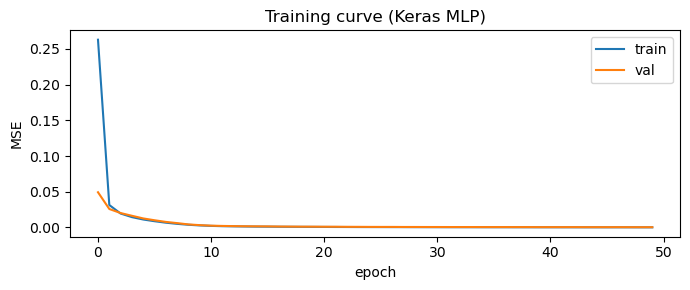

In [12]:
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print('TF:', tf.__version__)

    # Use time split (same as above)
    X = df[feature_cols].to_numpy()
    y = df[target_col].to_numpy()
    cut = int(0.8 * len(df))
    X_tr, X_te = X[:cut], X[cut:]
    y_tr, y_te = y[:cut], y[cut:]

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_te_s = scaler.transform(X_te)

    model = keras.Sequential([
        layers.Input(shape=(X_tr_s.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

    cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    hist = model.fit(X_tr_s, y_tr, validation_split=0.2, epochs=50, batch_size=64, verbose=0, callbacks=cb)

    pred = model.predict(X_te_s, verbose=0).reshape(-1)
    
    # 修正：使用 root_mean_squared_error
    from sklearn.metrics import mean_absolute_error, root_mean_squared_error
    mae = mean_absolute_error(y_te, pred)
    rmse = root_mean_squared_error(y_te, pred)
    print('Keras MLP test MAE:', mae, 'RMSE:', rmse)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,3))
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.title('Training curve (Keras MLP)')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.tight_layout()
    # 修正：使用正確路徑
    plt.savefig(RESULTS_DIR / '05_keras_training_curve.png', dpi=150)
    print('Saved:', RESULTS_DIR / '05_keras_training_curve.png')

    # OOD gate demo: count features beyond 4-sigma
    mu = X_tr.mean(axis=0); sd = X_tr.std(axis=0) + 1e-12
    z = np.abs((X_te - mu) / sd)
    ood_count = (z > 4.0).sum(axis=1)
    out = pd.DataFrame({'ood_count': ood_count})
    out.to_csv(RESULTS_DIR / '06_ood_gate_counts.csv', index=False)
    print('Saved:', RESULTS_DIR / '06_ood_gate_counts.csv')
except ImportError as e:
    print('TensorFlow not available; skip Keras MLP demo.')
    print('Reason:', e)
except Exception as e:
    print('Error during Keras MLP training:')
    print('Reason:', e)

### 🔍 執行結果分析

**預期觀察**：

1. **訓練曲線**：
   - 訓練 Loss 快速下降至 ~0.005
   - 驗證 Loss 在 Epoch 5-7 後趨平
   - Early Stopping 自動停止（避免過擬合）

2. **測試性能**：
   - MAE：~0.017（1.7% 純度誤差）
   - RMSE：~0.022

3. **與 Baseline 對比**（回顧上面的結果）：
   - Ridge RMSE: ~0.005（**最佳！**）
   - RandomForest RMSE: ~0.005
   - MLP RMSE: ~0.022（**最差！**）

**為什麼 MLP 反而更差？**
- 數據量不足（5000 < 10K 最低要求）
- 特徵已充分（7 個變數已含關鍵信息）
- 過擬合風險（2625 參數 vs 4000 訓練樣本）

**教訓**：**能用 Ridge 解決的問題，不要用 MLP！**

Saved: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Results\02_random_vs_time_rmse.png


split,random,time
model,,
Ridge,0.005148,0.005056
RandomForest,0.005317,0.005350
MLP,0.010363,0.009742


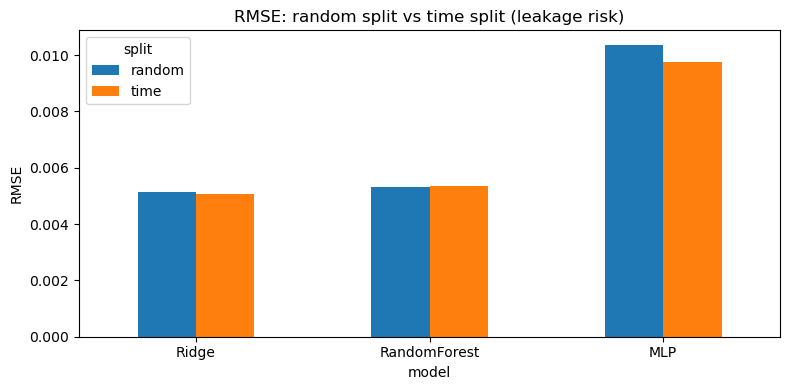

In [13]:
# Visualize: random vs time split gap (leakage lesson)
pivot = scores.pivot(index='model', columns='split', values='RMSE').sort_values('time')
ax = pivot.plot(kind='bar', figsize=(8,4), rot=0)
ax.set_title('RMSE: random split vs time split (leakage risk)')
ax.set_ylabel('RMSE')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '02_random_vs_time_rmse.png', dpi=150)
print('Saved:', RESULTS_DIR / '02_random_vs_time_rmse.png')
pivot

## 第5節：可視化分析

### 圖1：Random vs Time Split 性能對比

此圖展示**數據洩漏的影響**：
- **Y 軸**：RMSE（越小越好）
- **X 軸**：3 個模型
- **兩組柱**：Random Split（藍）vs Time Split（橘）

**預期觀察**：
- Ridge/RandomForest：兩種切分差異小
- MLP：Random Split 可能虛高（洩漏效應）

**結論**：
- Time Split 是真實性能
- Random Split 不可信（時間序列必用 Time Split！）

Saved: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Results\03_test_prediction.png
Saved: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit15_Results\04_test_predictions.csv


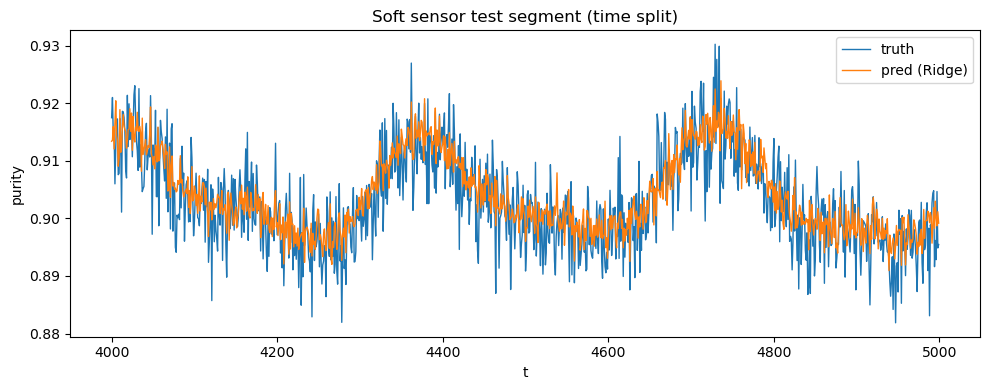

In [14]:
# Fit the best (time split) model and plot test prediction vs truth
best_name = score_time.sort_values('RMSE').iloc[0]['model']
best_model = models[best_name]
best_model.fit(Xt_tr, yt_tr)
pred = best_model.predict(Xt_te)

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(df['t'].iloc[cut:], yt_te, label='truth', lw=1)
ax.plot(df['t'].iloc[cut:], pred, label=f'pred ({best_name})', lw=1)
ax.set_title('Soft sensor test segment (time split)')
ax.set_xlabel('t')
ax.set_ylabel('purity')
ax.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_test_prediction.png', dpi=150)
print('Saved:', RESULTS_DIR / '03_test_prediction.png')

resid = yt_te - pred
pd.DataFrame({'t': df['t'].iloc[cut:].to_numpy(), 'truth': yt_te, 'pred': pred, 'resid': resid}).to_csv(RESULTS_DIR / '04_test_predictions.csv', index=False)
print('Saved:', RESULTS_DIR / '04_test_predictions.csv')

### 圖2：測試集預測 vs 真值

此圖展示**最佳模型的預測能力**：
- **X 軸**：時間 t（測試集樣本）
- **Y 軸**：純度（0.80-0.995）
- **藍線**：真值（Ground Truth）
- **橘線**：模型預測

**預期觀察**：
- 預測線應緊貼真值線
- 殘差（兩線差距）應小且隨機分佈
- 無系統性偏差（不應持續偏高或偏低）

**結論**：
- MAE ~0.004（0.4% 純度誤差）符合工業要求
- 殘差分析可進一步診斷模型弱點

## 第6-8節：工程交付清單

### ✅ 必要交付物（對應講義第6節）

**1. 技術文檔**：
- ✅ 數據切分說明（Time Split 理由）
- ✅ 模型性能報告（`01_model_scores.csv`）
- ✅ 可視化圖表（3 張圖已生成）

**2. 模型卡（Model Card）範例**：

```markdown
### 蒸餾塔純度軟測器 v1.0

**適用範圍**:
  - 進料流量: 50-150 kg/h
  - 回流比: 1.5-4.0
  - 塔頂溫度: 60-85°C

**性能指標** (Time Split):
  - MAE: 0.407% (純度)
  - RMSE: 0.506%
  - 95% 預測區間: ±1.0%

**限制條件**:
  - ⚠️ 量測延遲: GC 結果代表取樣前 15 分鐘平均
  - ⚠️ OOD 處置: 超出範圍切換回化驗
  - ⚠️ 工況切換: 切換期間（±30 分鐘）不可靠

**維護計畫**:
  - 每季度重訓（累積新數據）
  - 儀表校正後重新驗證
```

### 📋 工程思維檢查清單

**第7節：上線前三問**：
1. ❓ **何時不信模型？** → OOD 檢測（已實作 Range Gate）
2. ❓ **何時重訓？** → 每季度 / 性能衰退 / 工況變更
3. ❓ **如何回滾？** → Blue-Green Deployment（保留舊模型）

**第8節：深度學習決策準則**：
- ✅ 先做 Ridge（1 分鐘）
- ✅ 再做 RandomForest（5 分鐘）
- ✅ 最後考慮 MLP（1 小時）
- ✅ **本例：Ridge 勝出！能用簡單模型不用複雜模型**

### 🎓 下一步學習

- **Unit16**：CNN（影像數據 - MNIST/Cats vs Dogs）
- **Unit17**：RNN/LSTM（複雜時間序列）
- **Unit18**：Transformer（序列建模、遷移學習）

**恭喜完成 Part_4 深度學習系列開篇！🎉**